In [ ]:
# Import required packages
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from pathlib import Path

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers, models
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization, Activation
from keras.layers import Input
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## 1. Load the datasets

In your shared folder, right click 'ads_proj3' and hit add shortcut to gdrive. Make sure you add the shortcut to the 'MyDrive' folder.

In [ ]:
root = "/gdrive/MyDrive/ads_proj3/spring-2022-prj3-group9/"

In [ ]:
assert os.path.exists(root), 'Check the path to your root directory'

In [ ]:
lib_folder = os.path.join(root, "lib")
sys.path.insert(0, lib_folder)
from data_augmentation_utils import flip, rotate, distort, brightness, color

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [ ]:
train_images = os.path.join(root, 'data/train_data/images/')
clean_images_labels = os.path.join(root, 'data/train_data/clean_labels.csv')
noisy_images_labels = os.path.join(root, 'data/train_data/noisy_labels.csv')

In [ ]:
assert os.path.exists(train_images)
assert os.path.exists(clean_images_labels)
assert os.path.exists(noisy_images_labels)

In [ ]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    if i % 1000 == 0:
      print('.', end='')
    img_fn = train_images+f'{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt(clean_images_labels, delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt(noisy_images_labels, delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


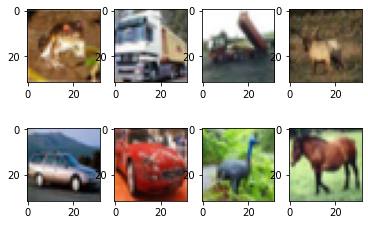

In [ ]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 1.2 Augment Data

We will perform 5 types of augmentation: flip (hflip or vflip), rotation, distortion, brightness, color.

### 1.2.1 Augment Clean Data

We will perform all 5 types of augmentation on the clean data.

In [ ]:
clean_augmented = os.path.join(root, 'output/clean_augmented')
Path(clean_augmented).mkdir(parents=True, exist_ok=True)

In [ ]:
def augment_clean(image):
  flipped = flip(image)
  rotated = rotate(image)
  distorted = distort(image)
  contrasted = brightness(image)
  colored = color(image)

  return flipped, rotated, distorted, contrasted, colored

In [ ]:
AUG_COUNT = 5
n_clean_aug = AUG_COUNT*n_clean_noisy
clean_aug_imgs = np.empty((n_clean_aug,32,32,3))
for i in range(n_clean_noisy):
  if i % 1000 == 0:
    print('.', end="")

  img_name = f'{i+1:05d}'
  flipped, rotated, distorted, contrasted, colored = augment_clean(imgs[i]/255)

  # save to outputs folder
  imageio.imwrite(clean_augmented+'/'+img_name+'_1.png', (flipped*255).astype(np.uint8))
  imageio.imwrite(clean_augmented+'/'+img_name+'_2.png', (rotated*255).astype(np.uint8))
  imageio.imwrite(clean_augmented+'/'+img_name+'_3.png', (distorted*255).astype(np.uint8))
  imageio.imwrite(clean_augmented+'/'+img_name+'_4.png', (contrasted*255).astype(np.uint8))
  imageio.imwrite(clean_augmented+'/'+img_name+'_5.png', (colored*255).astype(np.uint8))

  # add to clean augmented array
  clean_aug_imgs[AUG_COUNT*i] = flipped*255
  clean_aug_imgs[AUG_COUNT*i + 1] = rotated*255
  clean_aug_imgs[AUG_COUNT*i + 2] = distorted*255
  clean_aug_imgs[AUG_COUNT*i + 3] = contrasted*255
  clean_aug_imgs[AUG_COUNT*i + 4] = colored*255


In [ ]:
outputs_dir = root + 'output'
np.save(outputs_dir+'/img.npy', imgs)
np.save(outputs_dir+'/aug_clean_img.npy', clean_aug_imgs)

In [ ]:
# combine original + augmented
combined_data = np.vstack((imgs, clean_aug_imgs))
combined_data.shape

In [ ]:
# create labels for augmented data
aug_labels = np.empty(n_clean_aug)

for i in range(n_clean_noisy):
  label = clean_labels[i]
  aug_labels[5*i] = label
  aug_labels[5*i + 1] = label
  aug_labels[5*i + 2] = label
  aug_labels[5*i + 3] = label
  aug_labels[5*i + 4] = label

In [ ]:
# combined labels
combined_labels = np.concatenate((clean_labels, noisy_labels[10000:], aug_labels))
combined_labels.shape

(100000,)

In [ ]:
np.save(outputs_dir+'/combined_labels.npy', combined_labels)

### 1.2.2 Loading saved npy files

In [ ]:
outputs_dir = root + 'output'
orig_imgs = np.load(outputs_dir+'/img.npy')
aug_imgs = np.load(outputs_dir+'/aug_clean_img.npy')
combined_data = np.vstack((orig_imgs, aug_imgs))
combined_labels = np.load(outputs_dir+'/combined_labels.npy')

In [ ]:
del orig_imgs
del aug_imgs

## 1.3 Splitting data into train and test set 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_data, 
                                                    combined_labels, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
del combined_data

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [ ]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
def make_histogram(imgs, n_img):

  no_bins = 6
  bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
  feature_mtx = np.empty((n_img,3*(len(bins)-1)))
  i = 0
  for i in range(n_img):
      
      # Use the numbers of pixels in each bin for all three channels as the features
      feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
      feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
      feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
      
      # Concatenate three features
      feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
      i += 1

  return feature_mtx

In [ ]:
train_mtx = make_histogram(X_train, 75000)

In [ ]:
train_mtx.shape

(75000, 15)

In [ ]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(train_mtx, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [ ]:
# [DO NOT MODIFY THIS CELL]
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [ ]:
def CNN(input_size=(32,32,3)):

  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=input_size))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())

  model.add(Dense(64))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  return model

In [ ]:
model1 = CNN()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        1

In [ ]:
X_train_norm = X_train / 255

In [ ]:
X_test_norm = X_test / 255

In [ ]:
del X_train
del X_test

In [ ]:
model1.fit(X_train_norm, y_train, epochs=10)

In [ ]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    return model1.predict(image)

In [ ]:
K = len(set(y_train))

# Build the model using the functional API
# Input layer
i = Input(shape=X_train_norm[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

# Hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Output layer
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

# model description
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0     

In [ ]:
# Compile
model.compile(optimizer='adam',
			loss='sparse_categorical_crossentropy',
			metrics=['accuracy'])


In [ ]:
# Fit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

r = model.fit(X_train_norm, y_train, validation_split=0.2, epochs=100, callbacks=[callback])


Epoch 1/100
1875/1875 [==============================] - 20s 6ms/step - loss: 2.1747 - accuracy: 0.2051 - val_loss: 2.1853 - val_accuracy: 0.2441
Epoch 2/100
1875/1875 [==============================] - 10s 5ms/step - loss: 1.9174 - accuracy: 0.2733 - val_loss: 1.8576 - val_accuracy: 0.3014
Epoch 3/100
1875/1875 [==============================] - 10s 5ms/step - loss: 1.7834 - accuracy: 0.3288 - val_loss: 1.7768 - val_accuracy: 0.3299
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 1.6858 - accuracy: 0.3625 - val_loss: 1.7122 - val_accuracy: 0.3614
Epoch 5/100
1875/1875 [==============================] - 10s 6ms/step - loss: 1.6051 - accuracy: 0.3920 - val_loss: 1.7657 - val_accuracy: 0.3348
Epoch 6/100
1875/1875 [==============================] - 12s 6ms/step - loss: 1.5326 - accuracy: 0.4196 - val_loss: 1.5977 - val_accuracy: 0.3939
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 1.4613 - accuracy: 0.4437 - val_loss: 1.6274 -

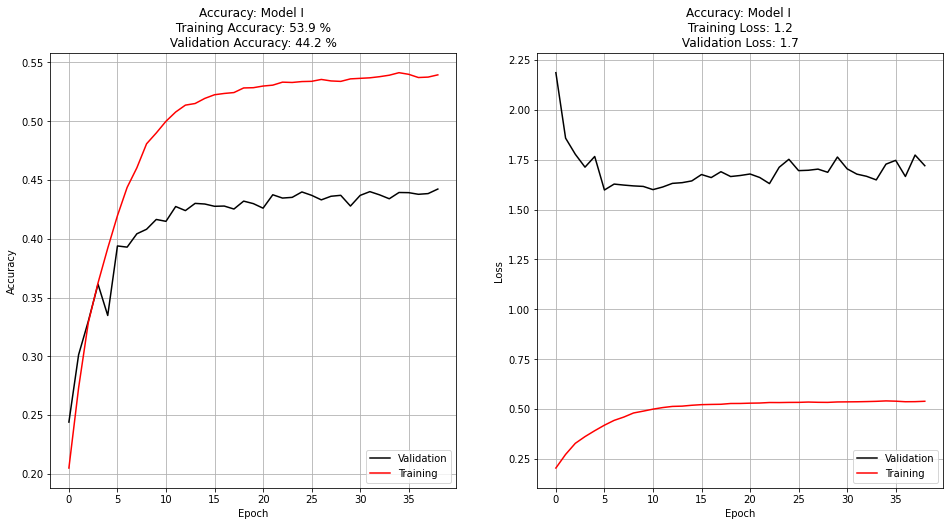

In [ ]:
# Display training results

fig, ax = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

# Plot accuracy
ax[0].plot(r.history["val_accuracy"], "k", label="Validation")
ax[0].plot(r.history["accuracy"], "r", label="Training")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy: Model I \n Training Accuracy: {:.1f} % \n Validation Accuracy: {:.1f} % ".format(
    r.history["accuracy"][-1] * 100,
    r.history["val_accuracy"][-1] * 100
))
ax[0].grid()
ax[0].legend(loc="lower right")

ax[1].plot(r.history["val_loss"], "k", label="Validation")
ax[1].plot(r.history["accuracy"], "r", label="Training")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Accuracy: Model I \n Training Loss: {:.1f} \n Validation Loss: {:.1f} ".format(
    r.history["loss"][-1],
    r.history["val_loss"][-1]
))
ax[1].grid()
ax[1].legend(loc="lower right")

plt.show()

In [ ]:
# flatten the label values
# y_train, y_test = y_train.flatten(), y_test.flatten()

In [ ]:
## improved model
# Train model based on the corrected labels
X_train_corrected_encode = model.predict(X_train_norm)
X_train_corrected = np.argmax(X_train_corrected_encode, axis=1)
noisy_label_corrected = tf.one_hot(X_train_corrected, depth=10)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model_improved = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=3, kernel_size=5, strides=2,
                           padding='same',             # dense: xW+b   
                           activation='relu',
                           input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10) 
])

BS = 70
INIT_LR = .001
EPOCHS = 100

model_improved.compile(optimizer="adam",
               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
              )

h = model_improved.fit(X_train_norm, 
                     noisy_label_corrected, 
                     batch_size=70, 
                     epochs=100, 
                     validation_split=0.2,
                     callbacks=[callback])

Epoch 1/100
858/858 [==============================] - 4s 4ms/step - loss: 1.1508 - categorical_accuracy: 0.6137 - val_loss: 1.0848 - val_categorical_accuracy: 0.6394
Epoch 2/100
858/858 [==============================] - 4s 5ms/step - loss: 1.0824 - categorical_accuracy: 0.6325 - val_loss: 1.3055 - val_categorical_accuracy: 0.6419
Epoch 3/100
858/858 [==============================] - 3s 4ms/step - loss: 1.0726 - categorical_accuracy: 0.6374 - val_loss: 1.0465 - val_categorical_accuracy: 0.6397
Epoch 4/100
858/858 [==============================] - 3s 4ms/step - loss: 1.0601 - categorical_accuracy: 0.6426 - val_loss: 1.1082 - val_categorical_accuracy: 0.6329
Epoch 5/100
858/858 [==============================] - 3s 4ms/step - loss: 1.0511 - categorical_accuracy: 0.6435 - val_loss: 1.0924 - val_categorical_accuracy: 0.6411
Epoch 6/100
858/858 [==============================] - 3s 4ms/step - loss: 1.0389 - categorical_accuracy: 0.6489 - val_loss: 1.4065 - val_categorical_accuracy: 0.597

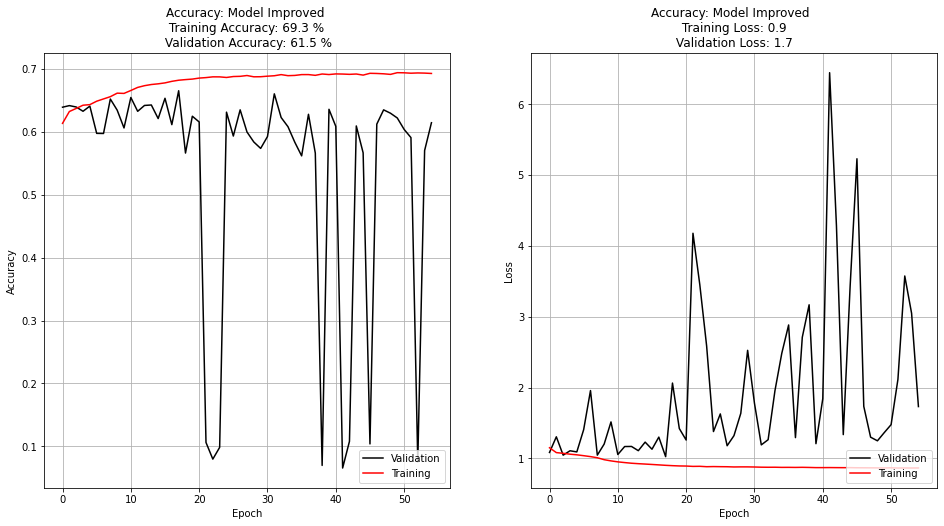

In [ ]:
# Display training results

fig, ax = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

# Plot accuracy
ax[0].plot(h.history["val_categorical_accuracy"], "k", label="Validation")
ax[0].plot(h.history["categorical_accuracy"], "r", label="Training")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy: Model Improved \n Training Accuracy: {:.1f} % \n Validation Accuracy: {:.1f} %".format(
    h.history["categorical_accuracy"][-1] * 100,
    h.history["val_categorical_accuracy"][-1] * 100
))
ax[0].grid()
ax[0].legend(loc="lower right")

ax[1].plot(h.history["val_loss"], "k", label="Validation")
ax[1].plot(h.history["loss"], "r", label="Training")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Accuracy: Model Improved  \n Training Loss: {:.1f} \n Validation Loss: {:.1f} ".format(
    h.history["loss"][-1],
    h.history["val_loss"][-1]
))
ax[1].grid()
ax[1].legend(loc="lower right")

plt.show()

In [ ]:
import joblib

In [ ]:
# save the model to disk
model_save = os.path.join(root, 'output/model_save.sav')
joblib.dump(model, model_save)

INFO:tensorflow:Assets written to: ram://e2ee28fb-0d8e-4270-ad7b-01757422b27c/assets


['/gdrive/MyDrive/ads_proj3/spring-2022-prj3-group9/output/model_save.sav']

In [ ]:
# load the model from disk
loaded_model = joblib.load(model_save)

### 2.3. Model II

In [ ]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
evaluation(model, y_test, X_test_norm)

In [ ]:
def eval_CNN(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = np.argmax(model(test_imgs), axis=-1)
    print(classification_report(y_true, y_pred))

In [ ]:
eval_CNN(model,y_test,X_test_norm)

### 3.1 Logistic Regression on Unseen Test Set

Do not run the following cell.

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

### 3.2 Logistic Regression on Augmented Dataset

In [ ]:
evaluation(baseline_model, y_test, X_test)

              precision    recall  f1-score   support

         0.0       0.25      0.35      0.29      2507
         1.0       0.17      0.18      0.17      2539
         2.0       0.12      0.07      0.08      2567
         3.0       0.14      0.11      0.12      2483
         4.0       0.21      0.33      0.26      2539
         5.0       0.18      0.09      0.12      2375
         6.0       0.20      0.33      0.25      2533
         7.0       0.28      0.07      0.12      2520
         8.0       0.22      0.34      0.27      2466
         9.0       0.19      0.14      0.16      2471

    accuracy                           0.20     25000
   macro avg       0.20      0.20      0.18     25000
weighted avg       0.20      0.20      0.18     25000



### 3.3 Model 1 on Augmented Dataset

In [ ]:
eval_CNN(model, y_test, X_test_norm)